In [1]:
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pyro.distributions.transforms as T

In [2]:
d = 1

dataset = torch.cat([torch.randn(64, d) -3, torch.randn(64, d) + 3])

In [3]:


import math
from functools import partial

import torch
import torch.nn as nn
from torch.distributions import Transform, constraints

from pyro.nn import DenseNN

from pyro.distributions.conditional import ConditionalTransformModule
from pyro.distributions.torch_transform import TransformModule


class ShiftScale(Transform):
    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, weights=None, bias=None, bound=None):
        super().__init__(cache_size=1)
        self.weights = weights
        self.bias = bias
        self.bound = bound

    def _call(self, x):
        assert len(x.shape) == 2
        a = self.weights() if callable(self.weights) else self.weights
        a = torch.eye(self.input_dim) + torch.diag(a)


        b = self.bias() if callable(self.bias) else self.bias
        return a * x + b

    def _inverse(self, y):
        assert len(y.shape) == 2
        a = self.weights() if callable(self.weights) else self.weights
        a = torch.eye(self.input_dim) + torch.diag(a)
        b = self.bias() if callable(self.bias) else self.bias
        return (y - b) / a

    def log_abs_det_jacobian(self, x, y):
        a = self.weights() if callable(self.weights) else self.weights
        a = torch.eye(self.input_dim) + torch.diag(a)
        J = a.diag().abs().log()
        assert len(J.shape) == 1
        return J.sum(-1)


class ShiftScaleTransform(ShiftScale, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim, bound=None):
        super().__init__(bound=bound)
        self.input_dim = input_dim
        self.weights = nn.Parameter(torch.Tensor(input_dim))
        self.bias = nn.Parameter(torch.Tensor(input_dim))
        self.reset_parameters()
        
        
    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.input_dim)
        self.weights.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()





In [4]:

class PositivePowerTransform(Transform):
    r"""
    Transform via the mapping
    :math:`y=\operatorname{sign}(x)|x|^{\text{exponent}}`.

    Whereas :class:`~torch.distributions.transforms.PowerTransform` allows
    arbitrary ``exponent`` and restricts domain and codomain to postive values,
    this class restricts ``exponent > 0`` and allows real domain and codomain.

    .. warning:: The Jacobian is typically zero or infinite at the origin.
    """
    domain = constraints.real
    codomain = constraints.real
    bijective = True
    sign = +1

    def __init__(self, exponent, *, cache_size=0, validate_args=None):
        super().__init__(cache_size=cache_size)
    
    def with_cache(self, cache_size=1):
        if self._cache_size == cache_size:
            return self
        return PositivePowerTransform(self.exponent, cache_size=cache_size)

    def _get_e(self):
#         return F.softplus(self.exponent)
        return self.exponent.exp()

    def _call(self, x):
        assert len(x.shape) == 2
        e = self._get_e()
        return x.abs().pow(e) * x.sign()

    def _inverse(self, y):
        assert len(y.shape) == 2
        e = self._get_e()
        return y.abs().pow(e.reciprocal()) * y.sign()

    def log_abs_det_jacobian(self, x, y):
        e = self._get_e()
        J =  e.log() + (y / x).log()
        assert len(J.shape) == 2
        return J.sum(-1)


    def forward_shape(self, shape):
        e = self._get_e()
        return torch.broadcast_shapes(shape, getattr(e, "shape", ()))


    def inverse_shape(self, shape):
        e = self._get_e()
        return torch.broadcast_shapes(shape, getattr(e, "shape", ()))


    
class PositivePowerTransformModule(PositivePowerTransform, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim):
        super().__init__(None)
        self.exponent = nn.Parameter(torch.zeros(input_dim))



In [5]:
base_dist = dist.Normal(torch.zeros(d), torch.ones(d))
num_layers = 4
transform = []
for l in range(num_layers - 1):
#     transform.append(T.affine_coupling(1))
    transform.append(ShiftScaleTransform(d))
#     transform.append(MatrixExponential(d))
#     transform.append(T.SoftplusTransform())
#     transform.append(LeakyReLUTransform(d))
#     transform.append(LeakyReLUTransformModule())
    transform.append(PositivePowerTransformModule(d))
#     transform.append(T.ELUTransform())
transform.append(ShiftScaleTransform(d))
# transform.append(MatrixExponential(d))


transform_modules = nn.ModuleList([m for m in transform if isinstance(m, nn.Module)])
flow_dist = dist.TransformedDistribution(base_dist, transform)


In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


count_parameters(transform_modules)

11

In [7]:
x = torch.linspace(-5, 5, 32)

In [8]:
flow_dist.log_prob(x[:, None]).shape

torch.Size([32])

In [9]:
y = flow_dist.sample((1024,))

<AxesSubplot:ylabel='Density'>

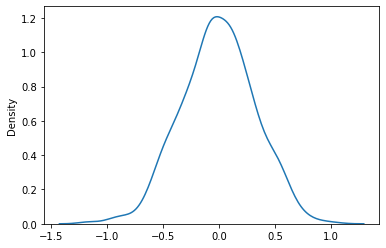

In [10]:
sns.kdeplot(y.detach().squeeze())

In [11]:
x = torch.linspace(-256, 256, 32768)

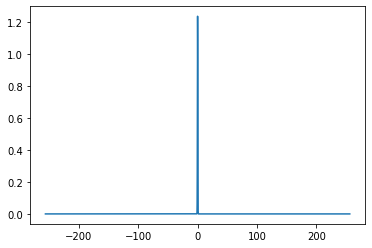

In [12]:
plt.plot(x, flow_dist.log_prob(x[:, None]).exp().detach().numpy().squeeze())

In [13]:
# matexp = MatrixExponential(d)

In [14]:
from torch.distributions.utils import _sum_rightmost


def log_prob(transformed_dist, value):
        """
        Scores the sample by inverting the transform(s) and computing the score
        using the score of the base distribution and the log abs det jacobian.
        """
        if transformed_dist._validate_args:
            transformed_dist._validate_sample(value)
        event_dim = len(transformed_dist.event_shape)
        log_prob = 0.0
        y = value
        for transform in reversed(transformed_dist.transforms):
            x = transform.inv(y)
            assert torch.allclose(transform(x), y),  transform
            print(transform, x.mean())
            event_dim += transform.domain.event_dim - transform.codomain.event_dim
            log_prob = log_prob - _sum_rightmost(transform.log_abs_det_jacobian(x, y),
                                                 event_dim - transform.domain.event_dim)
            y = x

        log_prob = log_prob + _sum_rightmost(transformed_dist.base_dist.log_prob(y),
                                             event_dim - len(transformed_dist.base_dist.event_shape))
        return log_prob
    
log_probs = log_prob(flow_dist, dataset)

ShiftScaleTransform() tensor(0.1940, grad_fn=<MeanBackward0>)
PositivePowerTransformModule() tensor(0.1940, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(0.1380, grad_fn=<MeanBackward0>)
PositivePowerTransformModule() tensor(0.1380, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(0.2215, grad_fn=<MeanBackward0>)
PositivePowerTransformModule() tensor(0.2215, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(0.4604, grad_fn=<MeanBackward0>)


In [15]:
# print(count_parameters(transform_modules))

In [16]:
def log_prob(transformed_dist, value):
        """
        Scores the sample by inverting the transform(s) and computing the score
        using the score of the base distribution and the log abs det jacobian.
        """
        if transformed_dist._validate_args:
            transformed_dist._validate_sample(value)
        event_dim = len(transformed_dist.event_shape)
        log_prob = 0.0
        y = value
        for transform in reversed(transformed_dist.transforms):
            x = transform.inv(y)
            print(transform, x.mean())
            event_dim += transform.domain.event_dim - transform.codomain.event_dim
            log_prob = log_prob - _sum_rightmost(transform.log_abs_det_jacobian(x, y),
                                                 event_dim - transform.domain.event_dim)
            y = x

        log_prob = log_prob + _sum_rightmost(transformed_dist.base_dist.log_prob(y),
                                             event_dim - len(transformed_dist.base_dist.event_shape))
        return log_prob


step: 0, loss: 49.91716003417969


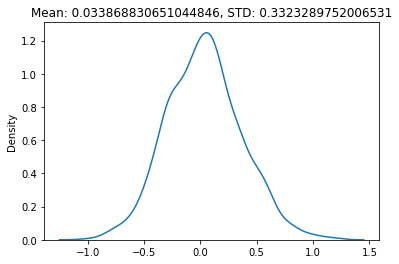

step: 500, loss: 2.76263689994812


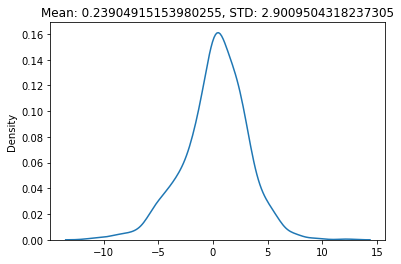

step: 1000, loss: 2.2678720951080322


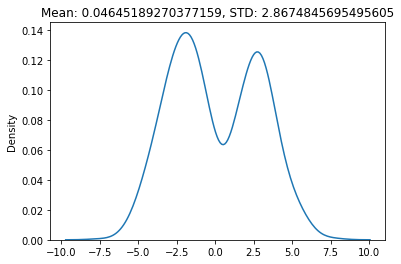

step: 1500, loss: 2.1624600887298584


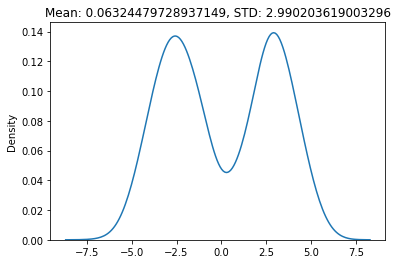

step: 2000, loss: 2.1062121391296387


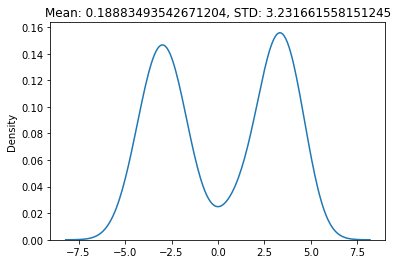

step: 2500, loss: 2.098487377166748


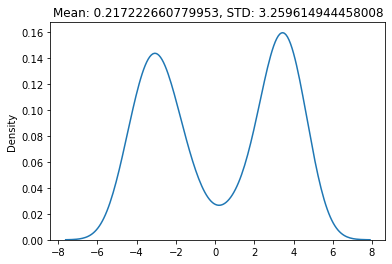

KeyboardInterrupt: 

In [17]:
steps = 32768
optimizer = torch.optim.Adam(transform_modules.parameters(), lr=1e-2)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
#     loss = -log_prob(flow_dist, dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    
    
    
    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

        sample = flow_dist.sample((1000,)).squeeze().numpy()
        sns.kdeplot(sample)
        plt.title(f"Mean: {sample.mean()}, STD: {sample.std()}")
        plt.show()

In [ ]:
with torch.no_grad():
    sample = flow_dist.sample((1000,)).squeeze().numpy()
    sns.kdeplot(sample)
    plt.title(f"Mean: {sample.mean()}, STD: {sample.std()}")

In [ ]:
x = torch.linspace(-8, 8, 128)

In [ ]:
plt.plot(x, flow_dist.log_prob(x[:, None]).exp().detach().numpy().squeeze())

In [ ]:
sns.kdeplot(dataset.squeeze())

In [ ]:
# 